## Ejemplo de Pendulum

In [1]:
# env = gym.make("Pendulum-v1", render_mode="human")
# observation, info = env.reset()

# for _ in range(250):
#     action = env.action_space.sample()  # agent policy that uses the observation and info
#     observation, reward, terminated, truncated, info = env.step(action)

#     print(observation, reward, terminated, truncated, info)

#     if terminated or truncated:
#         observation, info = env.reset()

# env.close()

## Basic

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [3]:
#env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
env = gym.make("Pendulum-v1", render_mode="human", g=9.81)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())

# ********************************************************************

def calculate_reward(observ, torque, target_angle): # Todos los valores estan en radianes
    theta = math.atan2(observ[1],observ[0])
    theta_dot = observ[2]
    
    theta_n = ((theta + np.pi) % (2*np.pi)) - np.pi

    theta_error = np.abs(theta_n - target_angle)
    
    torque_castigo = (torque**2) - np.minimum(2-np.absolute(torque),0)
    costs = (theta_error**2) + 0.1 * (theta_dot**2) + torque_castigo
    # if theta_error <= 0.26: # ~ 15°
    #     reward_n = -costs + math.exp(-(8*theta_error)**2)
    # else:
    #     reward_n = -costs
    reward_n = -costs
    return torch.tensor(np.array([reward_n]), device=device)

# ********************************************************************

def discretize_action(action, num_intervals):
    # Normaliza la acción continua al rango [0, 1]
    normalized_action = (action + 2.0) / 4.0
    # Calcula el índice de la acción discreta
    discrete_action = int(normalized_action * num_intervals)
    return np.clip(discrete_action, 0, num_intervals-1)

def undiscretize_action(discrete_action, num_intervals):
     # Calcula el valor normalizado dentro del rango [0, 1]
    normalized_action = discrete_action / num_intervals
    # Escala el valor al rango original [-2.0, 2.0]
    continuous_action = (normalized_action * 4.0) - 2.0
    return continuous_action


True


## Replay Memory

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN Algorithm

### Q-network

In [5]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.active1 = nn.PReLU(128, random.uniform(0.1, 0.5))    ##
        self.layer2 = nn.Linear(128, 128)
        self.active2 = nn.PReLU(128, random.uniform(0.1, 0.5))    ##
        self.output_layer = nn.Linear(128, n_actions)
    def forward(self, x):
        #x = F.prelu(self.norm1(self.layer1(x)), 0.5*torch.rand(1, dtype=torch.float32, device=device))
        #x = F.prelu(self.norm2(self.layer2(x)), 0.5*torch.rand(1, dtype=torch.float32, device=device))
        #x = F.relu(self.layer1(x))
        #x = F.relu(self.layer2(x))
        x = self.layer1(x)
        x = self.active1(x)
        x = self.layer2(x)
        x = self.active2(x)
        return self.output_layer(x)

## Training

In [6]:
BATCH_SIZE = 128    # number of transitions sampled from the replay buffer
GAMMA = 0.99        # discount factor as mentioned in the previous section
EPS_START = 0.9     # starting value of epsilon
EPS_END = 0.05      # final value of epsilon
EPS_DECAY = 1000    # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005         # update rate of the target network
LR = 1e-4           # learning rate of the ``AdamW`` optimizer

# ****************************************************************************
# ****************************************************************************

n_actions = 10

saved_checkpoint = False        # Si se encuentra algun checkpoint guardado y se desea cargar

target_angle = -120
changing_target = False
targets_options = np.array([0, 30, 60, 90, 120, 150, 180, -150, -120, -90, -60, -30])

# ****************************************************************************
if torch.cuda.is_available():
    #num_episodes = 1000
    num_episodes = 50
else:
    #num_episodes = 50
    num_episodes = 10
# ****************************************************************************

state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

if saved_checkpoint:
    checkpoint = torch.load("checkpoints/Pendulum_checkpoint_#.tar") # Cambiar el # por el episodio de checkpoint guardado
    start_episode = checkpoint['episodes']
    policy_net.load_state_dict(checkpoint['model_state_dict'])
    target_net.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    target_net.load_state_dict(policy_net.state_dict())
    start_episode = 0

# ****************************************************************************
# ****************************************************************************

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state, n_actions):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # *************************************************************************
    with torch.no_grad():
        value_discrete = policy_net(state).max(1).indices.view(1, 1)
    if sample > eps_threshold:
        newvalue = value_discrete
    else:
        #noise = np.random.normal(0, 0.3, size=None)
        #value_noise = undiscretize_action(value_discrete, n_actions) + noise
        #newvalue = discretize_action(value_noise, n_actions)
        newvalue = discretize_action(env.action_space.sample().item(), n_actions)  # ***************************
        
    # *************************************************************************
    if newvalue == 0.0:
        return torch.tensor([0], dtype=torch.long, device=device)
    else:
        return torch.tensor([newvalue], dtype=torch.long, device=device)
        
episode_rewards = []

def plot_rewards(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Time steps (gray lines=episode)')
    plt.ylabel('Reward')
    #plt.plot(rewards_t.numpy(), linewidth=0.2)                 # Cada valor de reward
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())                                 # Promedios del reward
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training Loop

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action).unsqueeze(1)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    state_action_values = policy_net(state_batch).gather(1,action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, dtype=torch.float32, device=device)

    with torch.no_grad():
        actions_target = target_net(non_final_next_states)
        actions_index = actions_target.argmax(dim=1)
        next_state_values[non_final_mask] = actions_target[non_final_mask, actions_index]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


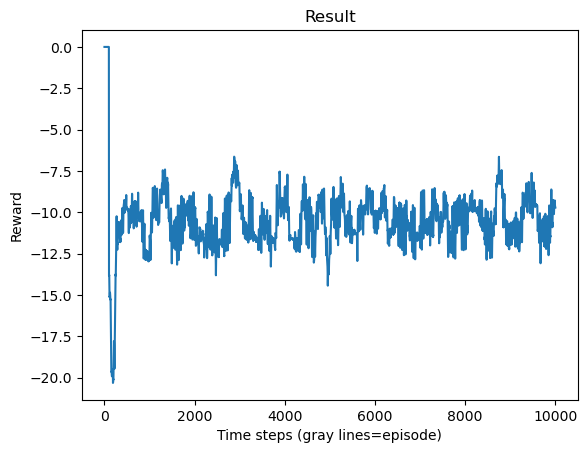

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
new_rewards = []
epoch = 0
epoch_save_checkspoints = num_episodes//5
target_step = num_episodes//len(targets_options)
i_target = 0
u_option = 0

for i_episode in range(start_episode, num_episodes):

    ## *********************************CAMBIO DEL TARGET_ANGLE****************************************
    if changing_target and (i_target == target_step):
        target_angle = targets_options[u_option]
        u_option += 1
        i_target = 1
        print("Target angle >> ", target_angle)
    else:
        i_target += 1

    ## ************************************************************************************************

    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    print("Episode >> ", i_episode)
    for t in count():
        action = select_action(state, n_actions)
        action_step = undiscretize_action(action.cpu().detach().numpy(), n_actions)
        observation, reward, terminated, truncated, _ = env.step(action_step)

        # ///////////////////////////////////////////////////////////////////////////////////
        reward = calculate_reward(observation, action_step.item(), math.radians(target_angle))
        # ///////////////////////////////////////////////////////////////////////////////////

        #done = terminated or truncated
        done = terminated or truncated or (np.absolute(action_step.item())>2)

        ## *********************************************************************************
        pole_angle = math.degrees(math.atan2(observation[1],observation[0]))
        print(np.array([pole_angle, action_step.item(), reward.item()]))
        new_rewards.append(reward.item())
        ## *********************************************************************************

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards = episode_rewards + new_rewards
            new_rewards = []
            plot_rewards()
            break

    ## ***********************************************SAVE CHECKPOINTS*********************************************
    if epoch == epoch_save_checkspoints:
        epoch = 1
        checkpoint = {
        'episodes': i_episode,
        'model_state_dict': policy_net_state_dict,
        'optimizer_state_dict': target_net_state_dict,
        }
        torch.save(checkpoint, f"checkpoints/Pendulum_checkpoint_{i_episode}_discrete.tar")
    else:
        epoch += 1
        

## ***********************************************SAVE & LOAD models*******************************************
# Guardar el modelo
torch.save(policy_net.state_dict(), f"models/Pendulum_{num_episodes}eps_discrete.pth")
## ************************************************************************************************************

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()
env.close()